# Initialization

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from result_saver import SaverProvider

provider = SaverProvider()

# Generate Extreme Data

In [312]:
from soft_info import RepCodeIQSimulator

DEVICE = 'ibm_sherbrooke'
DISTANCE = 11
ROUNDS = 11
OTHER_DATE = '2021-11-11'
_RESETS = True
LOGICAL = 0 # NOT NEEDED FOR EXTREME IQ BCS HARDCODED 0

_is_hex = True
if DEVICE == 'ibmq_mumbai':
    _is_hex = False

# Initialize simulator
simulator = RepCodeIQSimulator(provider, DISTANCE, ROUNDS, DEVICE, _is_hex=_is_hex, _resets = _RESETS, other_date=OTHER_DATE)

Found jobs for backend ibm_sherbrooke with closest execution date 2023-10-27 08:32:22.841567+00:00.
Found jobs for backend ibm_sherbrooke with closest execution date 2023-10-27 08:32:22.841567+00:00.
Searching for ibm_sherbrooke and 23.10.27_07h46_300pts_2std


In [325]:
# Get noise model
p1Q = 0
pZ = 0
pRE = 0
pXY = 0

p2Q = 1e-2
# pRO = 15e-2
pRO = 0

multiplicator = 10e-2
p1Q = 5e-2 * multiplicator
p2Q = 5e-2 * multiplicator
pXY = 5e-2 * multiplicator
pZ = 5e-2 * multiplicator
pRO = 8e-5 * multiplicator # slightly lower than device median because no soft flips
pRE = 5e-3 * multiplicator

p1Q = multiplicator
p2Q = multiplicator
pXY = multiplicator
pZ = multiplicator
# pRO = multiplicator
# pRE = multiplicator

noise_model = simulator.get_noise_model(p1Q, p2Q, pXY, pZ, pRO, pRE)

In [326]:
SHOTS = int(1e4)
P_AMBIG = 0.05

extreme_IQ_data = simulator.generate_extreme_IQ(SHOTS, P_AMBIG, noise_model=noise_model)
print(extreme_IQ_data.shape)

100%|██████████| 10000/10000 [00:07<00:00, 1268.82it/s]

(10000, 121)


# Get counts from IQ data

In [327]:
from src import cpp_soft_info

print(cpp_soft_info.get_counts(extreme_IQ_data, simulator.qubit_mapping, simulator.grid_dict, simulator.processed_scaler_dict, ROUNDS))

{'00000000000 0000000000 0000000000 0000000000 0000000000 0000000000 0001000000 0001000000 1100010000 1000000000 0100000101 0001000110': 1, '00000000000 0000000000 0000000000 0000000000 0000000000 0000000000 1010000010 0010000000 0010010000 1100000010 1001000100 0000000100': 1, '00000000000 0000000000 0000000000 0000000000 0000000000 0000001000 0110000001 0000000010 0000000010 1011100000 0000000000 0010000100': 1, '00000000000 0000000000 0000000000 0000000000 0000000000 0000010000 1000000010 1000000010 0000010100 0000000000 0001011001 0000000010': 1, '00000000000 0000000000 0000000000 0000000000 0000000000 0100000000 0000000000 0000000000 0000001001 0100001000 1010010000 0001100011': 1, '00000000000 0000000000 0000000000 0000000000 0000000000 0100000010 0000000000 1000000001 0000011000 0000100011 0001001100 0000001000': 1, '00000000000 0000000000 0000000000 0000000000 0000000000 1000001000 0100001000 0010011000 1100000000 1100000100 0110011000 0000100000': 1, '00000000000 0000000000 00

# Decode IQ data

In [328]:
import pymatching
import stim


circuit = stim.Circuit.generated("repetition_code:memory",
                                distance=DISTANCE,
                                rounds=ROUNDS,
                                after_clifford_depolarization=p2Q, #two-qubit-fidelity,
                                after_reset_flip_probability=pRE, #reset error,
                                before_measure_flip_probability=pRO, #measurement error,
                                before_round_data_depolarization=(pXY+pZ)/2) #idle error)
# print(circuit)

model = circuit.detector_error_model(decompose_errors=True)
matching = pymatching.Matching.from_detector_error_model(model)

P_DATA = 1e-2
P_MIXED = 1e-2
P_MEAS = P_AMBIG

In [329]:
from src import cpp_soft_info

matching = pymatching.Matching.from_detector_error_model(model)
# cpp_soft_info.reweight_edges_based_on_error_probs(matching._matching_graph, counts, False, "spitz")

result = cpp_soft_info.decode_IQ_shots(matching._matching_graph, extreme_IQ_data,
                                           ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict,
                                           simulator.processed_scaler_dict, p_data=-1, p_mixed=-1,
                                           common_measure=-1, _bimodal=True, merge_strategy = "replace", _detailed=True)
print("num_errors:", result.num_errors, "out of", len(extreme_IQ_data), "shots")

num_errors: 115 out of 10000 shots


In [330]:
matching = pymatching.Matching.from_detector_error_model(model)
result_flat = cpp_soft_info.decode_IQ_shots_flat(matching._matching_graph, extreme_IQ_data,
                                           ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict,
                                           simulator.processed_scaler_dict, _detailed=True)
print("num_errors:", result_flat.num_errors, "out of", len(extreme_IQ_data), "shots")


num_errors: 102 out of 10000 shots


In [331]:
matching = pymatching.Matching.from_detector_error_model(model)

p_meas = P_MEAS + pRO
p_meas = -1
# p_meas = 45e-2

result_informed = cpp_soft_info.decode_IQ_shots_flat_informed(matching._matching_graph, extreme_IQ_data, 
                                           ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict, simulator.processed_scaler_dict,
                                           p_data = -1, p_mixed = -1, p_meas = p_meas, common_measure=-1, _detailed=True)

print("num_errors:", result_informed.num_errors, "out of", len(extreme_IQ_data), "shots")
         
# takes 1s

num_errors: 538 out of 10000 shots


# Plot the results

In [332]:
print("\nIQ:", result.indices, "\nFlat:", result_flat.indices, "\nInformed", result_informed.indices)


IQ: [100, 165, 368, 392, 451, 621, 767, 779, 780, 813, 848, 929, 1003, 1182, 1238, 1313, 1370, 1555, 1820, 1824, 1855, 2012, 2031, 2250, 2369, 2376, 2430, 2482, 2544, 2578, 2743, 2772, 2780, 2825, 3236, 3288, 3325, 3833, 3870, 3991, 3998, 4217, 4257, 4277, 4475, 4521, 4617, 4637, 5079, 5302, 5330, 5348, 5462, 5534, 5549, 5694, 5778, 5809, 5837, 5854, 5941, 5963, 5999, 6036, 6079, 6299, 6350, 6372, 6504, 6573, 6638, 6856, 6930, 6969, 7048, 7176, 7278, 7468, 7559, 7590, 7658, 7683, 7968, 8012, 8041, 8083, 8097, 8111, 8198, 8213, 8255, 8437, 8498, 8612, 8624, 8643, 8744, 8830, 8877, 8905, 8929, 9005, 9027, 9055, 9139, 9168, 9194, 9363, 9438, 9481, 9492, 9541, 9783, 9805, 9944] 
Flat: [97, 100, 264, 308, 568, 704, 720, 913, 974, 1003, 1214, 1414, 1617, 1640, 1680, 2044, 2092, 2238, 2250, 2321, 2359, 2482, 2657, 2726, 2743, 2786, 2921, 2955, 3026, 3141, 3164, 3236, 3302, 3331, 3485, 3680, 3833, 3848, 4128, 4217, 4227, 4289, 4321, 4377, 4383, 4506, 4522, 4530, 4536, 4660, 4813, 5212, 5348, 

-----IQ-----


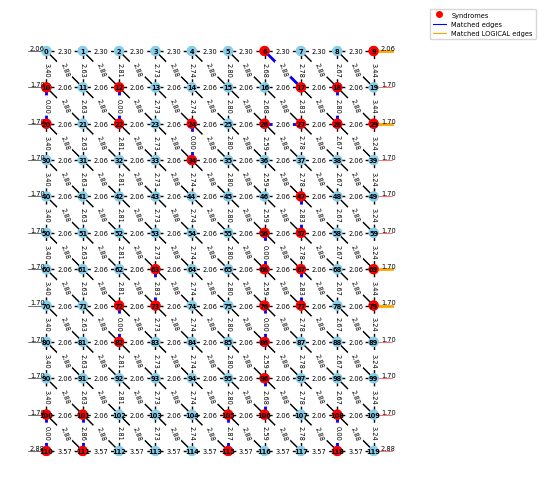

-----flat-----


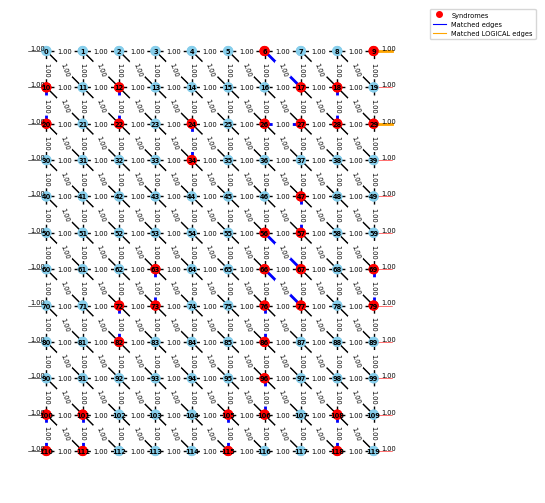

-----INFORMED-----


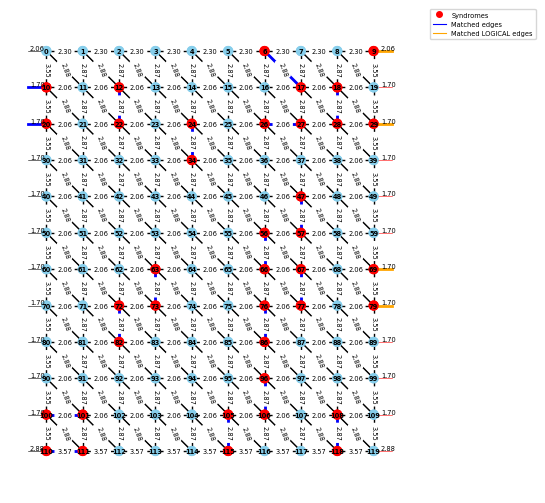

In [333]:
from soft_info import draw_matching_graph


index = 158

fig_size = (4, 13)
scale_factor = 0.4

to_be_result = result
details = to_be_result.error_details[index]
print("-----IQ-----")
draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)

to_be_result = result_flat
details = to_be_result.error_details[index]
print("-----flat-----")
draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)

to_be_result = result_informed
details = to_be_result.error_details[index]
print("-----INFORMED-----")
draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)


In [334]:
# print the differences between the two lists using sets
print("diff between IQ and informed:")
print(set(result_informed.indices) - set(result.indices))
print(set(result.indices) - set(result_informed.indices))

print()
print("diff between flat and informed:")
print(set(result.indices) - set(result_flat.indices))
print(set(result_flat.indices) - set(result.indices))



diff between IQ and informed:
{4110, 6160, 8210, 21, 2072, 4123, 6176, 4131, 2092, 6190, 2103, 2104, 6200, 58, 4159, 68, 4169, 74, 8269, 6226, 4208, 8311, 4219, 2174, 2176, 8325, 142, 2194, 4243, 148, 4249, 8349, 8359, 6312, 4268, 176, 6320, 8374, 185, 4289, 205, 8399, 6352, 4306, 6359, 6364, 2271, 8419, 8422, 232, 8426, 8442, 6395, 6399, 6400, 6404, 2321, 4369, 277, 4374, 4377, 6426, 2333, 2345, 6444, 2357, 8513, 4421, 8528, 338, 4435, 8532, 8534, 356, 8548, 4459, 4463, 2416, 8562, 2425, 2440, 393, 6543, 8593, 4502, 6551, 8600, 8601, 4506, 2459, 6560, 6564, 4519, 2473, 4522, 4536, 2499, 2501, 8658, 2515, 6636, 8687, 4597, 2562, 4623, 6675, 8724, 548, 2599, 8750, 559, 4660, 8764, 585, 6738, 2643, 6742, 4698, 605, 4701, 2657, 4707, 6755, 616, 8810, 6765, 6770, 2681, 2682, 4729, 8826, 2690, 8838, 4745, 8847, 656, 8863, 2726, 2730, 6826, 8880, 6836, 2741, 694, 6848, 8897, 2754, 8898, 2758, 4806, 714, 6858, 4813, 720, 4816, 6867, 6872, 8927, 736, 2786, 740, 752, 2810, 4872, 778, 2828, 4878